# Setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Linear regression using the Normal Equation

In [4]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


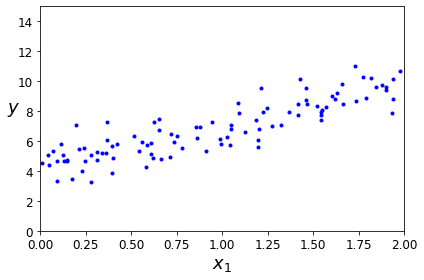

In [5]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [6]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [7]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [8]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

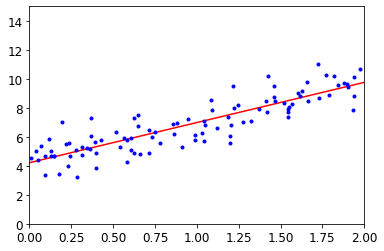

In [9]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

adding labels and legend to the plot

Saving figure linear_model_predictions_plot


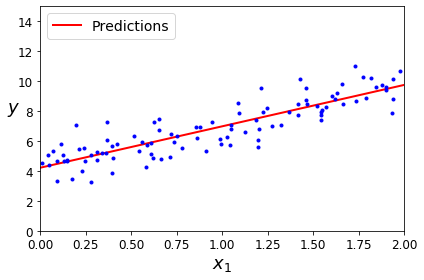

In [10]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

# sklearn models

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [12]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])


The LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for "least squares"), which you could call directly:

In [13]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

 
This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the pseudoinverse of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly:

# Linear regression using batch gradient descent

# a
[6 Marks]
Write a simple implementation of a least-squares solution to linear regression that applies an iterative update to adjust the weights. Demonstrate the success of your approach on the sample data loaded below, and visualize the best fit plotted as a line (consider using linspace) against a scatter plot of the x and y test values

In [14]:
# Student: Onur Surucu
# Student Id: 0968305
num_iter = 300
learn_rate = 0.01
m = (np.shape(X))[0]
theta = np.random.randn(2,1)

for iteration in range(num_iter):
    grads = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - learn_rate * grads

[0, 2, 0, 15]

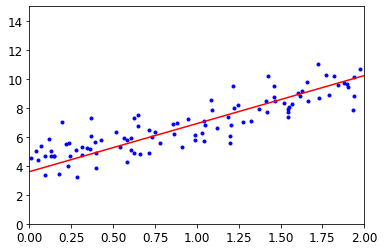

In [15]:
X_axis = np.linspace(0, 2, 100)
y_axis = theta[1][0] * X_axis + theta[0][0]

plt.plot(X, y, "b.")
plt.plot(X_axis, y_axis, "r-")
plt.axis([0, 2, 0, 15])

# b
[6 Marks]
Load data on movie ratings, revenue, metadata etc. Split data into a relevant set for training, testing and classification. Explain your choice of split. It is ok if you decide to split into these subsets after part c -> if you do so, mention this at the end of your explanation.
Explanation:

In [16]:
### An example to load a csv file
import pandas as pd 
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

#Importing the dataset
links_small = pd.read_csv('links_small.csv')
meta_data=pd.read_csv('movies_metadata.csv', low_memory=False) # You may wish to specify types, or process columns once read
ratings_small=pd.read_csv('ratings_small.csv')

#------------DATA PREPROCESSING--------------

# The following line is one way of cleaning up the genres field - there are more verbose ways of doing this that are easier for a human to read
meta_data['genres'] = meta_data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
meta_data['year'] = pd.to_datetime(meta_data['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)


# sort the whole dataframe by using movieId, then reset the index.
ratings_small = (
    ratings_small.sort_values("movieId").reset_index(drop=True).drop(columns="userId")
)

# Create new dataframe to assign new id and rating values 
new_ratings = pd.DataFrame(columns=["id", "rating"])

# initialize the rating average and the iteration number
i = 0
rating_average = []


# Iterating thorugh the movieId to average the ratings and assign one value for each movie
for cell in ratings_small.movieId[1:]:
    i += 1
    rating_average.append(ratings_small.rating[i - 1]) #Append the rating with the same id
    
    #Check the previous column to be sure that the still the same rating is being iterated
    if cell == ratings_small.movieId[i - 1]:
        pass
    # Case for if the rating is not repeating at all, then assign the value without taking any average
    else:
        new_ratings = new_ratings.append(
            {
                "id": ratings_small.movieId[i - 1],
                "rating": sum(rating_average) / len(rating_average),
            },
            ignore_index=True,
        )
        rating_average = []

# Remove "-" to make the type from object to float
meta_data.id = meta_data.id.str.replace("-", "").astype("float64")
# Merge two dataset
meta_data = meta_data.merge(new_ratings, on="id", how="left")

# Change the data type from object to float
meta_data[['budget']] = pd.to_numeric(meta_data['budget'], errors='coerce')
meta_data[['vote_average']] = pd.to_numeric(meta_data['vote_average'], errors='coerce')
meta_data[['vote_count']] = pd.to_numeric(meta_data['vote_count'], errors='coerce')
meta_data[['popularity']] = pd.to_numeric(meta_data['popularity'], errors='coerce')


adult : 5
belongs_to_collection : 1698
budget : 1223
genres : 4069
homepage : 7673
id : 45436
imdb_id : 45417
original_language : 92
original_title : 43373
overview : 44307
popularity : 43757
poster_path : 45024
production_companies : 22708
production_countries : 2393
release_date : 17336
revenue : 6863
runtime : 353
spoken_languages : 1931
status : 6
tagline : 20283
title : 42277
video : 2
vote_average : 92
vote_count : 1820
year : 136
rating : 725


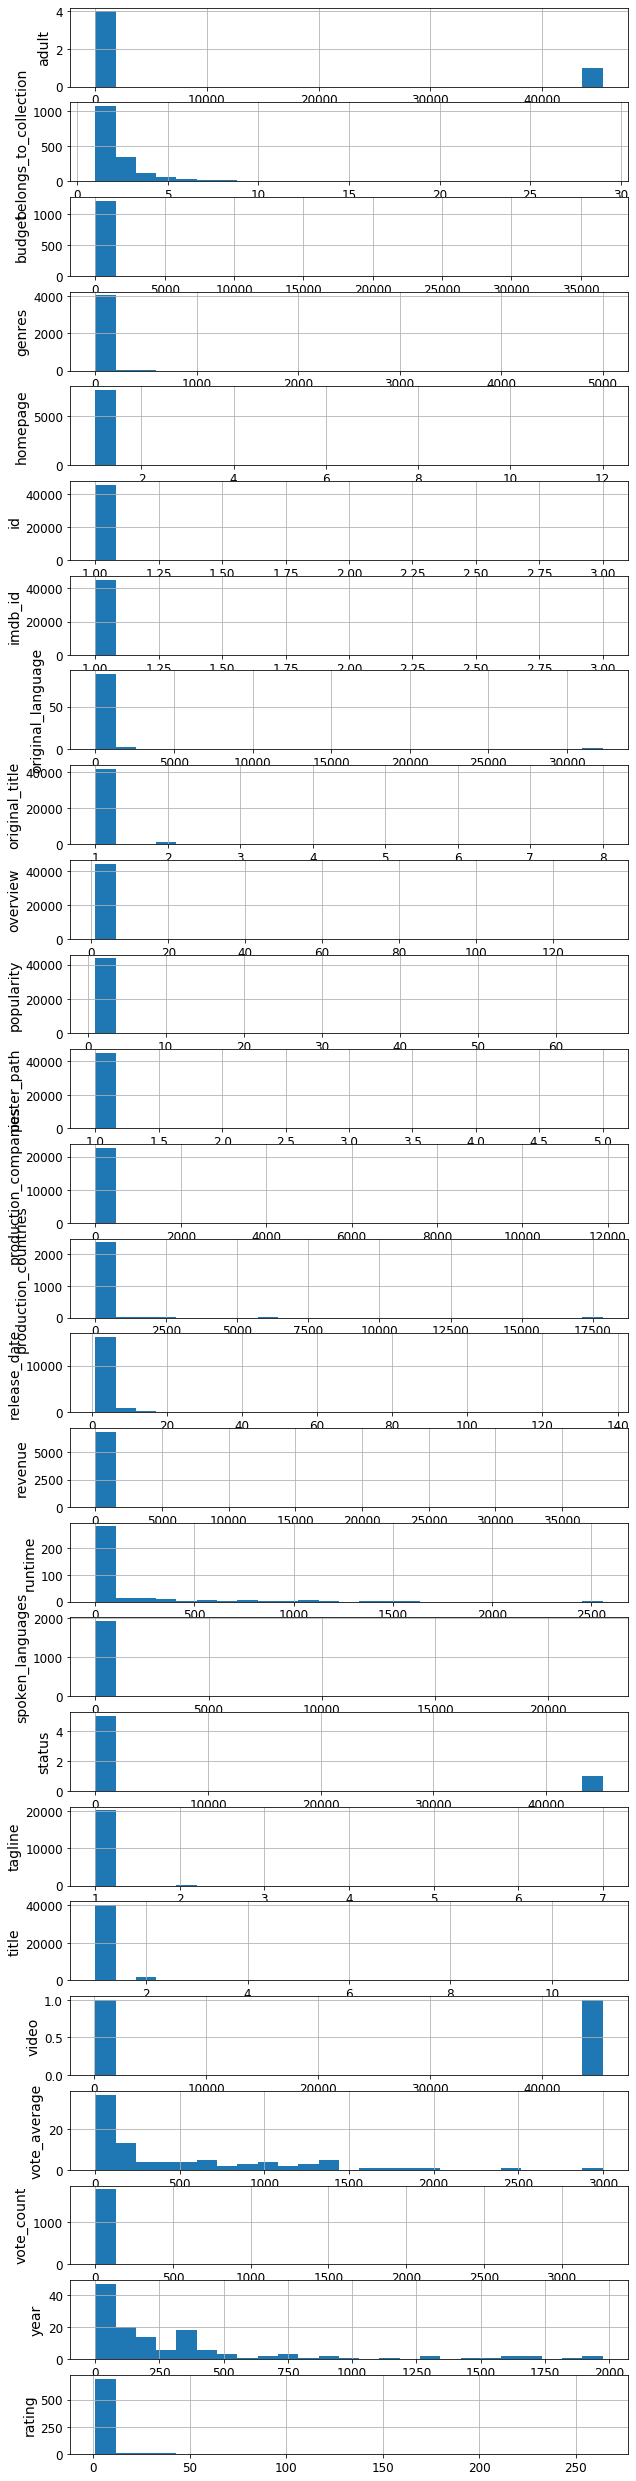

In [18]:
# Data binning and plotting to analyze the features that contain strings.
fig, axs = plt.subplots(len(meta_data.columns), figsize=(10, 45))
for n, col in enumerate(meta_data.columns):
    meta_data[col].value_counts().hist(ax=axs[n], bins=25)
    axs[n].set_ylabel(col)
    print(col,":",len(meta_data[col].value_counts()))

In [19]:
#-------FEATURE EXTRACTION--------------

#Drop redundant and non-relational data.
# Some features have too much unrelational information and some only contains 2 types for 10000 rows which has to be removed
meta_data = meta_data.drop(columns=["belongs_to_collection","homepage","original_title","overview","poster_path","tagline","title",'imdb_id', 'video', 'status'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4d92f5290>,
      dtype=object)

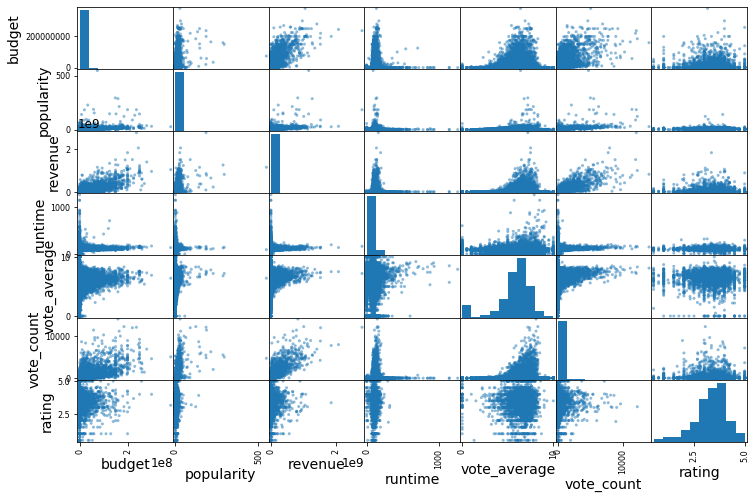

In [20]:
#Plot the each features against each other to analyze the correlation.  
from pandas.plotting import scatter_matrix

attributes = ['budget',
       'popularity', 
        'release_date', 'revenue', 'runtime',
       'vote_average', 'vote_count', 'rating','year']

scatter_matrix(meta_data[attributes], figsize=(12,8))

In [21]:
# Checking the correlation with a table
meta_data.corr()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,rating
budget,1.000000,-0.101671,0.449645,0.768776,0.134733,0.073494,0.676642,0.006915
id,-0.101671,1.000000,-0.083474,-0.071263,-0.121399,-0.167573,-0.064903,-0.014622
popularity,0.449645,-0.083474,1.000000,0.506179,0.129927,0.154399,0.559965,0.008054
revenue,0.768776,-0.071263,0.506179,1.000000,0.103917,0.083868,0.812022,-0.006912
runtime,0.134733,-0.121399,0.129927,0.103917,1.000000,0.158146,0.113539,-0.002078
vote_average,0.073494,-0.167573,0.154399,0.083868,0.158146,1.000000,0.123607,-0.003735
vote_count,0.676642,-0.064903,0.559965,0.812022,0.113539,0.123607,1.000000,0.003200
rating,0.006915,-0.014622,0.008054,-0.006912,-0.002078,-0.003735,0.003200,1.000000


# c
[6 Marks]

Organize the data into relevant features for predicting revenue. 

i. Explain your feature sets and organization. 
YOUR EXPLANATION HERE



ii. Plot movie revenue vs. rating as a scatter plot and discuss your findings. 
YOUR EXPLANATION HERE



iii. Visualize any other relationships you deem interesting and explain. 
YOUR EXPLANATION HERE

In [22]:
#i. Explain your feature sets and organization
# The data was processed from two stages: prepocessing and feature extraction
# Prepocessing: Two dataset had to be merged to add relations (features), some features were converted from dict to strings, the datatypes of the feature has been changed for plotting graphs 
# Feature extractin: Removal of feature contains data redundancy, removal of feature with non-relational data (sentence), removal of feature with very low correlation
meta_data.columns

Index(['adult', 'budget', 'genres', 'id', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'vote_average', 'vote_count',
       'year', 'rating'],
      dtype='object')

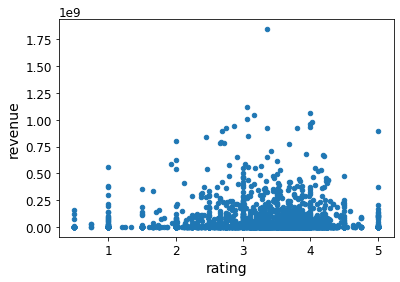

In [23]:
#ii. Plot movie revenue vs. rating as a scatter plot and discuss your findings.
meta_data.plot.scatter(x='rating',y='revenue')
# The correlation between the two graph can be considered as weak due to the weak reaction of the revenue output as the rating increases.
# That is why, the data points formed a partial eliptic shape. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4e2f31ed0>,
      dtype=object)

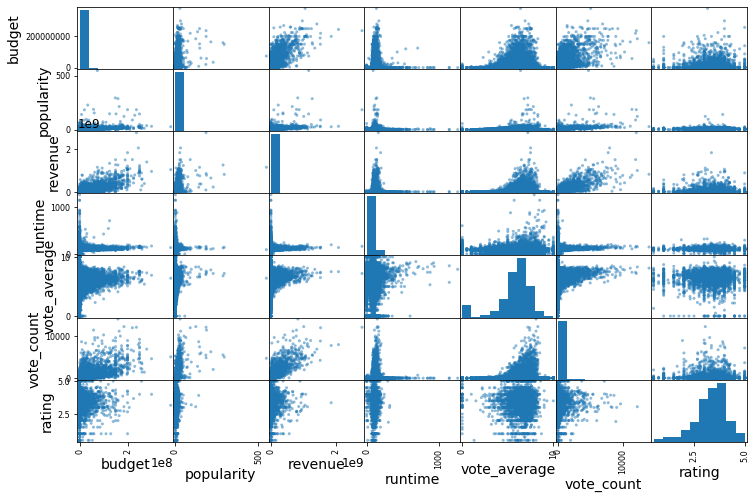

In [24]:
#iii. Visualize any other relationships you seem interesting and explain.
# The relations between the feature sets can be spotted by ploting them each other.
# This way it is pretty easy to observe the correlation between the features.

#Revenue has the highest correlation with the vote_count as can be seen from the scatter graph. Its shape is the closest to the eliptic form. 

#Plot the each features against each other to analyze the correlation.  
from pandas.plotting import scatter_matrix

attributes = ['budget',
       'popularity', 
        'release_date', 'revenue', 'runtime',
       'vote_average', 'vote_count', 'rating','year']

scatter_matrix(meta_data[attributes], figsize=(12,8))